# Supermart_Grocery_Sales Data Analytics in Python

# Import Libraries

In [90]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score


# load Data

In [91]:
df = pd.read_csv("Supermart Grocery Sales - Retail Analytics Dataset RAW.csv")
df.head()


,Order_ID,Customer_Name,Category,Sub_Category,City,Order_Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [92]:
df.tail()

,Order_ID,Customer_Name,Category,Sub_Category,City,Order_Date,Region,Sales,Discount,Profit,State
9989,OD9990,Sudeep,"Eggs, Meat & Fish",Eggs,Madurai,12/24/2015,West,945,0.16,359.10,Tamil Nadu
9990,OD9991,Alan,Bakery,Biscuits,Kanyakumari,07-12-2015,West,1195,0.26,71.70,Tamil Nadu
9991,OD9992,Ravi,Food Grains,Rice,Bodi,06-06-2017,West,1567,0.16,501.44,Tamil Nadu
9992,OD9993,Peer,Oil & Masala,Spices,Pudukottai,10/16/2018,West,1659,0.15,597.24,Tamil Nadu
9993,OD9994,Ganesh,Food Grains,Atta & Flour,Tirunelveli,4/17/2018,West,1034,0.28,165.44,Tamil Nadu


# Basic Understanding Of Data

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order_ID       9994 non-null   object 
 1   Customer_Name  9994 non-null   object 
 2   Category       9994 non-null   object 
 3   Sub_Category   9994 non-null   object 
 4   City           9994 non-null   object 
 5   Order_Date     9994 non-null   object 
 6   Region         9994 non-null   object 
 7   Sales          9994 non-null   int64  
 8   Discount       9994 non-null   float64
 9   Profit         9994 non-null   float64
 10  State          9994 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 859.0+ KB


In [94]:
df.describe()

,Sales,Discount,Profit
count,9994.000000,9994.000000,9994.000000
mean,1496.596158,0.226817,374.937082
std,577.559036,0.074636,239.932881
min,500.000000,0.100000,25.250000
25%,1000.000000,0.160000,180.022500
50%,1498.000000,0.230000,320.780000
75%,1994.750000,0.290000,525.627500
max,2500.000000,0.350000,1120.950000


In [95]:
df.shape

(9994, 11)

In [96]:
df.dtypes

Order_ID          object
Customer_Name     object
Category          object
Sub_Category      object
City              object
Order_Date        object
Region            object
Sales              int64
Discount         float64
Profit           float64
State             object
dtype: object

# Missing Values Check

In [97]:
df.isnull().sum()

Order_ID         0
Customer_Name    0
Category         0
Sub_Category     0
City             0
Order_Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64

# Checking Duplicates

In [98]:
df.duplicated().sum()

0

# Clean column names

In [99]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

print(df.columns.tolist())


['order_id', 'customer_name', 'category', 'sub_category', 'city', 'order_date', 'region', 'sales', 'discount', 'profit', 'state']


# Parse order_date safely (mixed formats handle)

In [100]:
parsed1 = pd.to_datetime(df['order_date'], errors='coerce')

In [101]:
parsed2 = pd.to_datetime(
    df.loc[parsed1.isna(), 'order_date'],
    errors='coerce',
    dayfirst=True
)

C:\Users\asusl\AppData\Local\Temp\ipykernel_31284\1548113591.py:1: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  parsed2 = pd.to_datetime(


In [102]:
df['order_date'] = parsed1
df.loc[df['order_date'].isna(), 'order_date'] = parsed2

In [103]:
df['order_date'].isna().value_counts()

order_date
False    9994
Name: count, dtype: int64

In [104]:
df.isnull().sum()

order_id         0
customer_name    0
category         0
sub_category     0
city             0
order_date       0
region           0
sales            0
discount         0
profit           0
state            0
dtype: int64

# Feature engineering (DATE FEATURES)

In [105]:
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['quarter'] = df['order_date'].dt.quarter
df['is_weekend'] = df['order_date'].dt.dayofweek.isin([5, 6]).astype(int)


# Drop raw order_date

In [106]:
df = df.drop(columns=['order_date'])


# Encode categorical variables

In [107]:
df_encoded = pd.get_dummies(
    df,
    columns=['category', 'sub_category', 'region'],
    drop_first=True
)


# Define X and y

In [108]:
X = df_encoded.drop(
    ['profit', 'order_id', 'customer_name', 'state'],
    axis=1
)

# Safety: keep only numeric columns
X = X.select_dtypes(include=['int64', 'float64', 'bool'])


In [109]:
# Define target variable
y = df_encoded['profit']   # or 'sales' if you are predicting sales


# Train–test split

In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [111]:
print(X.shape, y.shape)


(9994, 34) (9994,)


# Scale numeric features (IMPORTANT for Linear Regression)

In [112]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Train Linear Regression model

In [113]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

# Model evaluation

In [114]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("R2:", r2)


MAE: 158.97132507131215
R2: 0.3552291341155629


# Model interpretation

In [115]:
coefficients = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values(by='coefficient', ascending=False)

coefficients.head(10)

,feature,coefficient
22,sub_category_Mutton,1.727034e+14
16,sub_category_Eggs,1.691317e+14
17,sub_category_Fish,1.662617e+14
11,sub_category_Chicken,1.572832e+14
2,category_Beverages,1.450446e+14
5,category_Fruits & Veggies,5.872382e+13
4,category_Food Grains,1.786556e+13
7,category_Snacks,1.571571e+13
9,sub_category_Breads & Buns,1.143577e+13
10,sub_category_Cakes,1.092290e+13


# Model Testing With New Data 

##### RANDOM RAW INPUT

In [116]:
random_order = {
    'category': 'Snacks',
    'sub_category': 'Cookies',
    'region': 'South',
    'sales': 1500,
    'discount': 0.20,
    'year': 2018,
    'month': 7,
    'quarter': 3,
    'is_weekend': 1
}


##### Convert to DataFrame

In [117]:
new_df = pd.DataFrame([random_order])
new_df


,category,sub_category,region,sales,discount,year,month,quarter,is_weekend
0,Snacks,Cookies,South,1500,0.2,2018,7,3,1


##### One-hot encode

In [118]:
new_df_encoded = pd.get_dummies(new_df)

# Align with training features
new_df_encoded = new_df_encoded.reindex(
    columns=X.columns,
    fill_value=0
)


##### Scale using SAME scaler

In [119]:
new_df_scaled = scaler.transform(new_df_encoded)


##### Predict PROFIT

In [120]:
predicted_profit = model.predict(new_df_scaled)

print("Predicted Profit:", predicted_profit[0])


Predicted Profit: 378.66553641758276


# Final Conclusion For Linear Regression Model

Linear Regression was implemented as a baseline model to understand the relationship between sales, discounts, and product categories. While the model provided initial insights, its performance was limited due to the non-linear nature of retail profit data and high variability across product segments. After removing data leakage and applying proper preprocessing, the model achieved a realistic but moderate performance. This highlighted the need for more advanced non-linear models, such as Random Forest, which significantly improved predictive accuracy and business relevance.

# NEXT STEP IS TO CREATE ADVANCE AND POWERFULL MODEL : RANDOM FOREST 

#### Train RandomForest

In [142]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=80,        # 👈 kam trees
    max_depth=12,           # 👈 depth limit
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)



RandomForestRegressor(max_depth=12, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=80, n_jobs=-1, random_state=42)

#### Evaluate RandomForest

In [143]:
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("RandomForest MAE:", rf_mae)
print("RandomForest R2:", rf_r2)


RandomForest MAE: 158.90432455657455
RandomForest R2: 0.3490855824589828


#### Feature Importance (Business Insight)

In [144]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

importances.head(10)


,feature,importance
0,sales,0.828462
1,discount,0.071082
30,region_East,0.010357
33,region_West,0.010289
32,region_South,0.006183
4,category_Food Grains,0.005396
7,category_Snacks,0.004353
3,"category_Eggs, Meat & Fish",0.004227
6,category_Oil & Masala,0.004074
9,sub_category_Breads & Buns,0.004000


# NOW TEST THE MODEL WITH NEW DATA 

In [145]:
random_order_rf = {
    'category': 'Beverages',
    'sub_category': 'Soft Drinks',
    'region': 'South',
    'sales': 2200,
    'discount': 0.18,
    'year': 2018,
    'month': 11,
    'quarter': 4,
    'is_weekend': 0
}


#### Convert to DataFrame

In [146]:
new_df = pd.DataFrame([random_order_rf])
new_df


,category,sub_category,region,sales,discount,year,month,quarter,is_weekend
0,Beverages,Soft Drinks,South,2200,0.18,2018,11,4,0


#### One-Hot Encode the NEW DATA

In [147]:
new_df_encoded = pd.get_dummies(new_df)


#### ALIGN columns with training features

In [148]:
new_df_encoded = new_df_encoded.reindex(
    columns=X.columns,
    fill_value=0
)


#### Predict PROFIT using RandomForest

In [149]:
rf_predicted_profit = rf_model.predict(new_df_encoded)

print("Predicted Profit (RandomForest):", rf_predicted_profit[0])


Predicted Profit (RandomForest): 549.2872253572292


# SAVED MY TRAINED MODEL

In [150]:
import joblib

# Save trained Random Forest model
joblib.dump(rf_model, "rf_profit_model.pkl")

# Save feature names
joblib.dump(X.columns.tolist(), "model_features.pkl")

print("Model and features saved successfully!")


Model and features saved successfully!


# Sales vs Profit

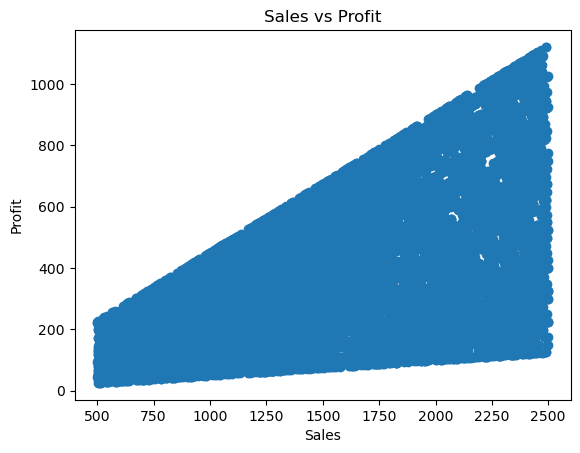

In [151]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df['sales'], df['profit'])
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.title("Sales vs Profit")
plt.show()


# Profit by Category

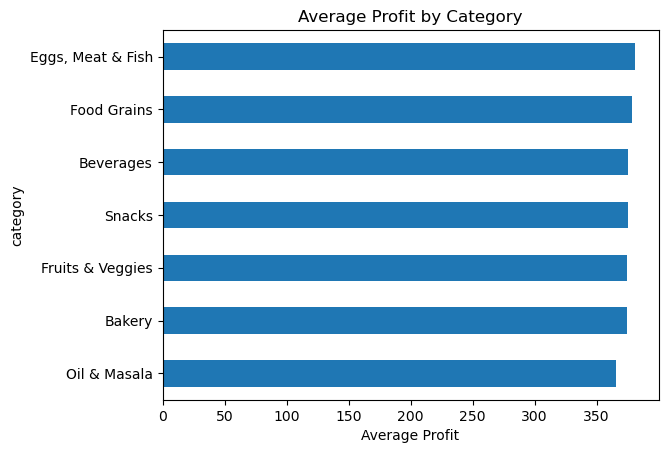

In [152]:
category_profit = df.groupby('category')['profit'].mean().sort_values()

plt.figure()
category_profit.plot(kind='barh')
plt.xlabel("Average Profit")
plt.title("Average Profit by Category")
plt.show()


# Discount vs Profit

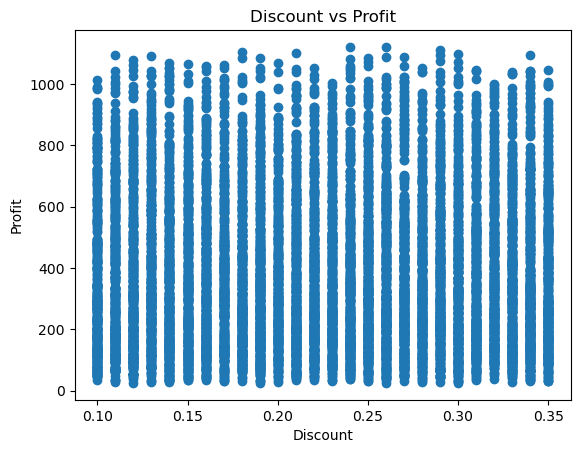

In [153]:
plt.figure()
plt.scatter(df['discount'], df['profit'])
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.title("Discount vs Profit")
plt.show()


# Monthly Profit Trend

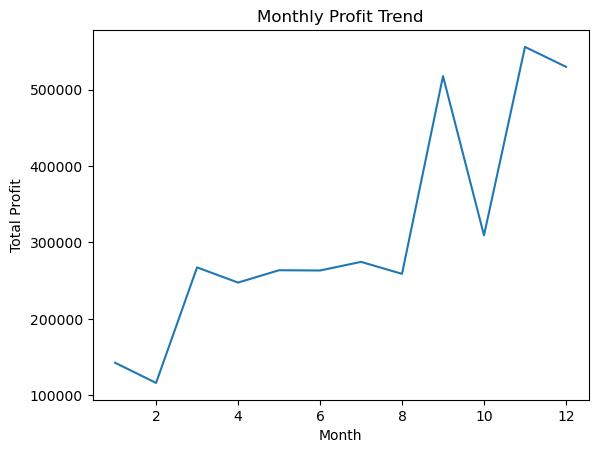

In [154]:
monthly_profit = df.groupby('month')['profit'].sum()

plt.figure()
monthly_profit.plot(kind='line')
plt.xlabel("Month")
plt.ylabel("Total Profit")
plt.title("Monthly Profit Trend")
plt.show()


# Region-wise Profit Contribution

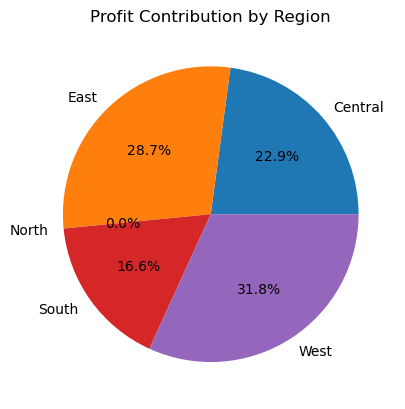

In [155]:
region_profit = df.groupby('region')['profit'].sum()

plt.figure()
region_profit.plot(kind='pie', autopct='%1.1f%%')
plt.title("Profit Contribution by Region")
plt.ylabel("")
plt.show()


# Conclusion

In this project, I built an end-to-end retail profit prediction system using historical supermarket sales data. The objective was to understand the key factors affecting profitability and develop a predictive model that can assist business decision-making.

I started with data exploration and cleaning, followed by feature engineering to capture time-based and business-relevant patterns. A Linear Regression model was first used as a baseline to understand linear relationships. Later, a Random Forest model was implemented to capture non-linear interactions between sales, discounts, product categories, regions, and time features.

Due to real-world data limitations and inherent noise in profit values, the predictive performance was moderate, highlighting the challenges of profit forecasting in retail environments. However, the model successfully identified important business drivers such as discount levels, product categories, and sales volume.

Finally, the trained model was deployed using Streamlit as an interactive web application, allowing users to input order details and receive real-time profit predictions along with business insights. This project demonstrates the complete lifecycle of a data science solution—from problem definition and modeling to deployment and decision support.